In [1210]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels para inferência
import statsmodels.api as sm
from statsmodels.formula.api import logit
from patsy import dmatrices

# scikit-learn para predição
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score

# Configurações
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# Carregar dados
df = pd.read_csv('coronarias_drop (1).csv', sep=';')

# Visualizar estrutura
print(df.head())
print(df.info())
print(df.describe())

   Unnamed: 0  SEXO  AH3  INFARTO  ANGEST  DIAB  ARTER  ARRIT  TABAG4  OBESO  \
0           0     0    1        0       0   0.0    0.0      0     0.0    1.0   
1           1     1    0        0       0   1.0    0.0      0     3.0    0.0   
2           4     1    2        1       0   0.0    0.0      0     0.0    0.0   
3           5     1    0        1       0   0.0    0.0      0     0.0    0.0   
4           6     1    0        0       0   1.0    0.0      0     2.0    0.0   

   GLO  IDADE1  ALTURA  PESO    IMC    COL   TRIG   PSR  PDR  
0    0    55.0    1.54  88.0  37.11  202.0  171.0  16.0  9.0  
1    0    53.0    1.63  73.0  27.48  225.0  167.0  11.0  8.0  
2    1    64.0    1.60  67.0  26.17  258.0   92.0  14.0  9.0  
3    1    64.0    1.80  87.0  26.85  184.0  110.0  13.0  8.0  
4    0    52.0    1.63  62.0  23.34  241.0  304.0  14.0  9.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dty

In [1211]:
# Opção 1: Remover linhas com missing
df_clean = df.dropna()

variaveis_numericas = ['IDADE1', 'ALTURA', 'PESO', 'IMC', 'PSR', 'PDR', 'COL' ,'TRIG']
variaveis_categoricas =['SEXO', 'DIAB', 'AH3', 'ANGEST', 'ARTER', 'ARRIT', 'OBESO', 'TABAG4', 'INFARTO','GLO']

In [1212]:
"""
# Exemplo: População tem valores muito maiores que Idade
# Aplicar log em variáveis com grande amplitude
df['log_populacao'] = np.log(df['populacao'] + 1)  # +1 para evitar log(0)

# Ou padronizar (necessário para scikit-learn se solvers como 'sag' ou 'saga')
scaler = StandardScaler()
df[['idade_scaled', 'renda_scaled']] = scaler.fit_transform(df[['idade', 'renda']])
"""

"\n# Exemplo: População tem valores muito maiores que Idade\n# Aplicar log em variáveis com grande amplitude\ndf['log_populacao'] = np.log(df['populacao'] + 1)  # +1 para evitar log(0)\n\n# Ou padronizar (necessário para scikit-learn se solvers como 'sag' ou 'saga')\nscaler = StandardScaler()\ndf[['idade_scaled', 'renda_scaled']] = scaler.fit_transform(df[['idade', 'renda']])\n"

In [1213]:
print(df.columns)

# Separar features e targetS

var_indep1 = ['IDADE1' ,'AH3', 'TABAG4', 'SEXO', 'DIAB','ARTER','IMC','PSR','PDR','COL']
var_dep1 = 'INFARTO'

var_indep2 = ['IDADE1' ,'AH3', 'TABAG4', 'SEXO', 'DIAB','ARTER','IMC','PSR','PDR','COL']
var_dep2 = 'ANGEST'

var_indep3 =  ['IDADE1' ,'AH3', 'TABAG4', 'SEXO', 'DIAB','ARTER','IMC','PSR','PDR','COL']
var_dep3 = 'GLO'

vars_all1 = [var_dep1] + var_indep1
data_clean1 = df[vars_all1].dropna()

X1 = data_clean1[var_indep1]
y1 = data_clean1[var_dep1]

vars_all2 = [var_dep2] + var_indep2
data_clean2 = df[vars_all2].dropna()

X2 = data_clean2[var_indep2]
y2 = data_clean2[var_dep2]

vars_all3 = [var_dep3] + var_indep3
data_clean3 = df[vars_all3].dropna()

X3 = data_clean3[var_indep3]
y3 = data_clean3[var_dep3]


Index(['Unnamed: 0', 'SEXO', 'AH3', 'INFARTO', 'ANGEST', 'DIAB', 'ARTER',
       'ARRIT', 'TABAG4', 'OBESO', 'GLO', 'IDADE1', 'ALTURA', 'PESO', 'IMC',
       'COL', 'TRIG', 'PSR', 'PDR'],
      dtype='object')


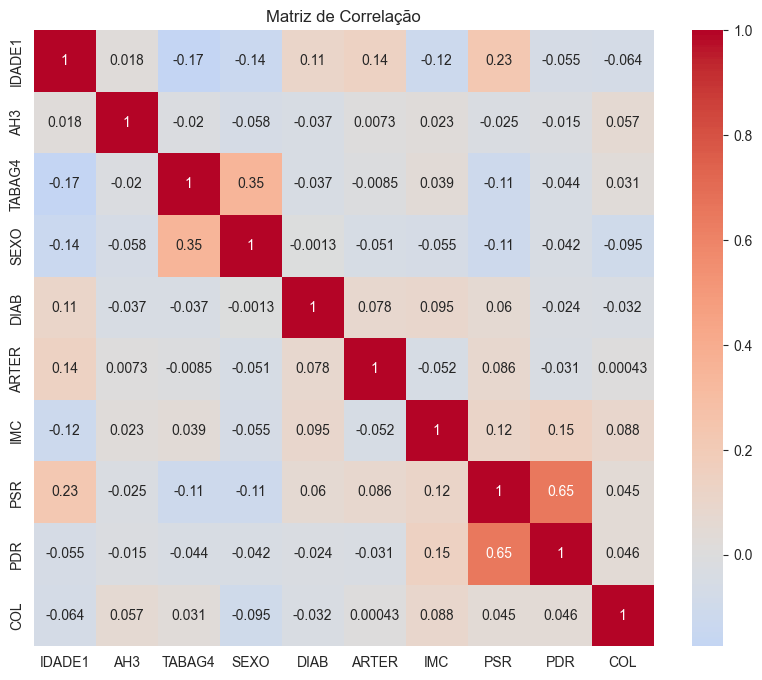

   feature         VIF
0    const  161.689814
1   IDADE1    1.215262
2      AH3    1.009856
3   TABAG4    1.173435
4     SEXO    1.178473
5     DIAB    1.037580
6    ARTER    1.038164
7      IMC    1.068406
8      PSR    2.033935
9      PDR    1.913118
10     COL    1.029986


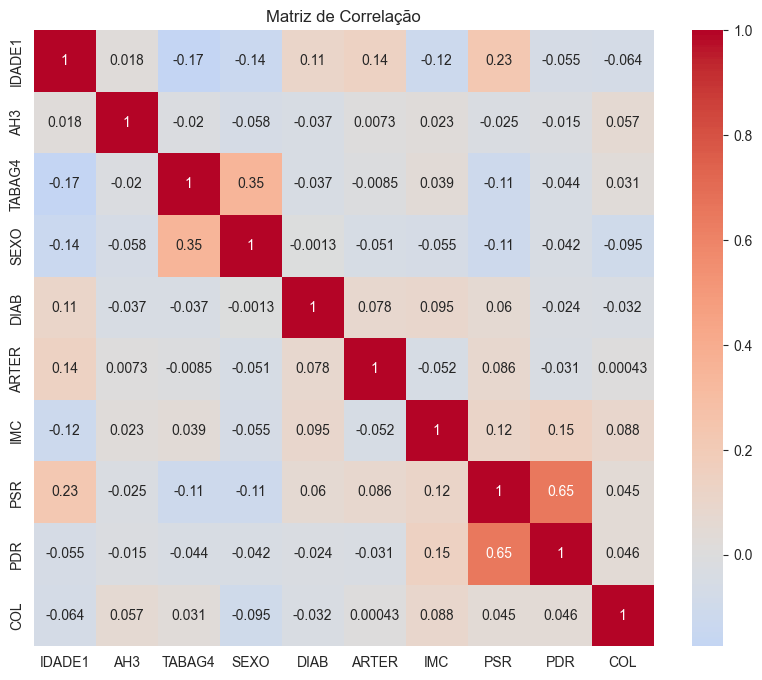

   feature         VIF
0    const  161.689814
1   IDADE1    1.215262
2      AH3    1.009856
3   TABAG4    1.173435
4     SEXO    1.178473
5     DIAB    1.037580
6    ARTER    1.038164
7      IMC    1.068406
8      PSR    2.033935
9      PDR    1.913118
10     COL    1.029986


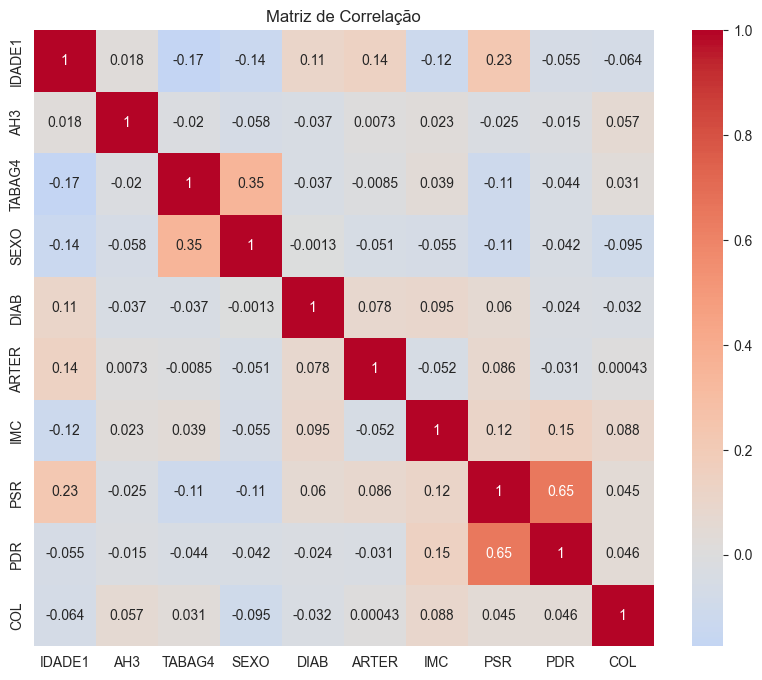

   feature         VIF
0    const  161.689814
1   IDADE1    1.215262
2      AH3    1.009856
3   TABAG4    1.173435
4     SEXO    1.178473
5     DIAB    1.037580
6    ARTER    1.038164
7      IMC    1.068406
8      PSR    2.033935
9      PDR    1.913118
10     COL    1.029986


In [1214]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular matriz de correlação (apenas numéricas)
correlation_matrix = df[X1.columns].corr()

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

# Criar um DataFrame para armazenar os VIFs
x_vif = sm.add_constant(X1.astype(float))  # Adiciona intercepto
vif_data = pd.DataFrame()
vif_data["feature"] = x_vif.columns

# Calcular o VIF para cada feature
# Nota: Usamos X_const (com o intercepto) para o cálculo do VIF
vif_data["VIF"] = [variance_inflation_factor(x_vif.values, i)
                   for i in range(len(x_vif.columns))]

print(vif_data)


# Calcular matriz de correlação (apenas numéricas)
correlation_matrix = df[X2.columns].corr()

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

# Criar um DataFrame para armazenar os VIFs
x_vif = sm.add_constant(X2.astype(float))  # Adiciona intercepto
vif_data = pd.DataFrame()
vif_data["feature"] = x_vif.columns

# Calcular o VIF para cada feature
# Nota: Usamos X_const (com o intercepto) para o cálculo do VIF
vif_data["VIF"] = [variance_inflation_factor(x_vif.values, i)
                   for i in range(len(x_vif.columns))]

print(vif_data)

# Calcular matriz de correlação (apenas numéricas)
correlation_matrix = df[X3.columns].corr()

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

# Criar um DataFrame para armazenar os VIFs
x_vif = sm.add_constant(X3.astype(float))  # Adiciona intercepto
vif_data = pd.DataFrame()
vif_data["feature"] = x_vif.columns

# Calcular o VIF para cada feature
# Nota: Usamos X_const (com o intercepto) para o cálculo do VIF
vif_data["VIF"] = [variance_inflation_factor(x_vif.values, i)
                   for i in range(len(x_vif.columns))]

print(vif_data)

In [1215]:
# Criar e ajustar modelo
modelo1_sm = sm.Logit(y1, X1)
resultado1_sm = modelo1_sm.fit()

modelo2_sm = sm.Logit(y2, X2)
resultado2_sm = modelo2_sm.fit()

modelo3_sm = sm.Logit(y3, X3)
resultado3_sm = modelo3_sm.fit()
# Visualizar sumário completo
print(resultado1_sm.summary())
print(resultado2_sm.summary())
print(resultado3_sm.summary())

Optimization terminated successfully.
         Current function value: 0.601937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559577
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                INFARTO   No. Observations:                  980
Model:                          Logit   Df Residuals:                      970
Method:                           MLE   Df Model:                            9
Date:                Tue, 21 Oct 2025   Pseudo R-squ.:                 0.05572
Time:                        00:19:49   Log-Likelihood:                -589.90
converged:                       True   LL-Null:                       -624.70
Covariance Type:            nonrobust   LLR p-value:                 1.814e-11
                 coef    std err          z      P>|z|      [0

In [1216]:
# Extrair coeficientes e p-valores
coeficientes = resultado1_sm.params
p_valores = resultado1_sm.pvalues

# Criar DataFrame
interpretacao = pd.DataFrame({
    'Coeficiente': coeficientes,
    'P-valor': p_valores,
    'Odds Ratio': np.exp(coeficientes),
    'Variacao_Percentual': (np.exp(coeficientes) - 1) * 100
})

# Filtrar variáveis significativas (p < 0.05)
interpretacao_sig = interpretacao[interpretacao['P-valor'] < 0.05].sort_values('Odds Ratio', ascending=False)
print(interpretacao_sig)

# Extrair coeficientes e p-valores
coeficientes = resultado2_sm.params
p_valores = resultado2_sm.pvalues

# Criar DataFrame
interpretacao = pd.DataFrame({
    'Coeficiente': coeficientes,
    'P-valor': p_valores,
    'Odds Ratio': np.exp(coeficientes),
    'Variacao_Percentual': (np.exp(coeficientes) - 1) * 100
})

# Filtrar variáveis significativas (p < 0.05)
interpretacao_sig = interpretacao[interpretacao['P-valor'] < 0.05].sort_values('Odds Ratio', ascending=False)
print(interpretacao_sig)

# Extrair coeficientes e p-valores
coeficientes = resultado3_sm.params
p_valores = resultado3_sm.pvalues

# Criar DataFrame
interpretacao = pd.DataFrame({
    'Coeficiente': coeficientes,
    'P-valor': p_valores,
    'Odds Ratio': np.exp(coeficientes),
    'Variacao_Percentual': (np.exp(coeficientes) - 1) * 100
})

# Filtrar variáveis significativas (p < 0.05)
interpretacao_sig = interpretacao.sort_values('Odds Ratio', ascending=False)
print(interpretacao_sig)

        Coeficiente   P-valor  Odds Ratio  Variacao_Percentual
DIAB       0.661894  0.000258    1.938461            93.846070
SEXO       0.402095  0.024322    1.494953            49.495332
TABAG4     0.213659  0.000674    1.238200            23.820016
PDR        0.174261  0.028967    1.190366            19.036650
PSR       -0.228522  0.000001    0.795709           -20.429123
      Coeficiente   P-valor  Odds Ratio  Variacao_Percentual
SEXO    -0.365151  0.020025    0.694092           -30.590839
DIAB    -0.455513  0.011518    0.634123           -36.587711
        Coeficiente       P-valor  Odds Ratio  Variacao_Percentual
SEXO       0.986891  7.906132e-09    2.682879           168.287927
DIAB       0.952403  2.550082e-05    2.591931           159.193083
ARTER      0.350974  4.563890e-02    1.420451            42.045057
AH3        0.276642  1.798744e-03    1.318694            31.869430
TABAG4     0.132947  4.926971e-02    1.142189            14.218908
IDADE1     0.030881  1.654287e-06    

In [1217]:
# Teste de Hosmer-Lemeshow (goodness-of-fit)
from scipy import stats

# Matriz de confusão
y_pred_sm = resultado1_sm.predict(X1) > 0.5
from sklearn.metrics import confusion_matrix
cm_sm = confusion_matrix(y1, y_pred_sm)
print("Matriz de Confusão:\n", cm_sm)

# Pseudo R²
print(f"Pseudo R² (McFadden): {resultado1_sm.prsquared:.4f}")

# AIC e BIC (quanto menor, melhor)
print(f"AIC: {resultado1_sm.aic:.2f}")
print(f"BIC: {resultado1_sm.bic:.2f}")

#MODELO2
# Matriz de confusão
y_pred_sm = resultado2_sm.predict(X2) > 0.5
from sklearn.metrics import confusion_matrix
cm_sm = confusion_matrix(y2, y_pred_sm)
print("Matriz de Confusão:\n", cm_sm)

# Pseudo R²
print(f"Pseudo R² (McFadden): {resultado2_sm.prsquared:.4f}")

# AIC e BIC (quanto menor, melhor)
print(f"AIC: {resultado2_sm.aic:.2f}")
print(f"BIC: {resultado2_sm.bic:.2f}")

#MODELO3
# Matriz de confusão
y_pred_sm = resultado3_sm.predict(X3) > 0.5
from sklearn.metrics import confusion_matrix
cm_sm = confusion_matrix(y3, y_pred_sm)
print("Matriz de Confusão:\n", cm_sm)

# Pseudo R²
print(f"Pseudo R² (McFadden): {resultado3_sm.prsquared:.4f}")

# AIC e BIC (quanto menor, melhor)
print(f"AIC: {resultado3_sm.aic:.2f}")
print(f"BIC: {resultado3_sm.bic:.2f}")

Matriz de Confusão:
 [[608  44]
 [270  58]]
Pseudo R² (McFadden): 0.0557
AIC: 1199.80
BIC: 1248.67
Matriz de Confusão:
 [[514  69]
 [324  73]]
Pseudo R² (McFadden): 0.0166
AIC: 1321.11
BIC: 1369.98
Matriz de Confusão:
 [[ 81 224]
 [ 45 630]]
Pseudo R² (McFadden): 0.0976
AIC: 1116.77
BIC: 1165.65


In [1218]:
# Separar features e target
X1_sklearn = data_clean1.drop(var_dep1, axis=1)
y1_sklearn = data_clean1[var_dep1]

X2_sklearn = data_clean2.drop(var_dep2, axis=1)
y2_sklearn = data_clean2[var_dep2]

X3_sklearn = data_clean3.drop(var_dep3, axis=1)
y3_sklearn = data_clean3[var_dep3]
# Dividir treino/teste
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1_sklearn, y1_sklearn, 
    test_size=0.3, 
    random_state=42, 
    stratify=y1_sklearn  # mantém proporção de classes
)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2_sklearn, y2_sklearn, 
    test_size=0.3, 
    random_state=42, 
    stratify=y2_sklearn  # mantém proporção de classes
)
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3_sklearn, y3_sklearn, 
    test_size=0.3, 
    random_state=42, 
    stratify=y3_sklearn  # mantém proporção de classes
)

# Padronizar (importante para solvers 'sag' e 'saga')
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

X3_train_scaled = scaler.fit_transform(X3_train)
X3_test_scaled = scaler.transform(X3_test)

In [1219]:
# Criar modelo
# C é o inverso da força de regularização (menor C = maior regularização)
modelo1_sklearn = LogisticRegression(
    penalty='l2',           # Regularização L2 (Ridge)
    C=0.001,                  # Força de regularização
    solver='saga',         # Solver padrão
    max_iter=1000,          # Aumentar se não convergir
    random_state=42,
    class_weight='balanced' # Útil para classes desbalanceadas
)

modelo2_sklearn = LogisticRegression(
    penalty='l2',           # Regularização L2 (Ridge)
    C=0.001,                  # Força de regularização
    solver='saga',         # Solver padrão
    max_iter=1000,          # Aumentar se não convergir
    random_state=42,
    class_weight='balanced' # Útil para classes desbalanceadas
)

modelo3_sklearn = LogisticRegression(
    penalty='l2',           # Regularização L2 (Ridge)
    C=0.001,                  # Força de regularização
    solver='saga',         # Solver padrão
    max_iter=1000,          # Aumentar se não convergir
    random_state=42,
    class_weight='balanced' # Útil para classes desbalanceadas
)
# Treinar
modelo1_sklearn.fit(X1_train_scaled, y1_train)
modelo2_sklearn.fit(X2_train_scaled, y2_train)
modelo3_sklearn.fit(X3_train_scaled, y3_train)

# Coeficientes
coef_sklearn = pd.DataFrame({
    'Variavel': X1_train.columns,
    'Coeficiente': modelo1_sklearn.coef_[0],
    'Odds_Ratio': np.exp(modelo1_sklearn.coef_[0])
}).sort_values('Coeficiente', ascending=False)
print('Modelo1')
print(coef_sklearn)

coef_sklearn = pd.DataFrame({
    'Variavel': X2_train.columns,
    'Coeficiente': modelo2_sklearn.coef_[0],
    'Odds_Ratio': np.exp(modelo2_sklearn.coef_[0])
}).sort_values('Coeficiente', ascending=False)
print('\nModelo2\n')
print(coef_sklearn)

coef_sklearn = pd.DataFrame({
    'Variavel': X3_train.columns,
    'Coeficiente': modelo3_sklearn.coef_[0],
    'Odds_Ratio': np.exp(modelo3_sklearn.coef_[0])
}).sort_values('Coeficiente', ascending=False)
print('\nModelo3\n')
print(coef_sklearn)

Modelo1
  Variavel  Coeficiente  Odds_Ratio
2   TABAG4     0.043834    1.044809
3     SEXO     0.041806    1.042692
4     DIAB     0.032819    1.033363
5    ARTER     0.010049    1.010100
1      AH3     0.009595    1.009641
0   IDADE1    -0.001718    0.998283
9      COL    -0.004039    0.995969
6      IMC    -0.016826    0.983315
8      PDR    -0.022254    0.977991
7      PSR    -0.045170    0.955835

Modelo2

  Variavel  Coeficiente  Odds_Ratio
7      PSR     0.028163    1.028564
6      IMC     0.015912    1.016039
8      PDR     0.015891    1.016018
1      AH3     0.008765    1.008803
9      COL     0.003302    1.003307
0   IDADE1     0.002797    1.002801
5    ARTER    -0.002535    0.997468
2   TABAG4    -0.012088    0.987985
4     DIAB    -0.020015    0.980184
3     SEXO    -0.027675    0.972705

Modelo3

  Variavel  Coeficiente  Odds_Ratio
3     SEXO     0.065522    1.067717
0   IDADE1     0.060709    1.062589
4     DIAB     0.041811    1.042698
2   TABAG4     0.039562    1.040355


=== MÉTRICAS DE PERFORMANCE ===
Acurácia: 0.5646
Precisão: 0.3986
Recall: 0.6020
F1-Score: 0.4797
ROC-AUC: 0.6086
=== MÉTRICAS DE PERFORMANCE ===
Acurácia: 0.5544
Precisão: 0.4571
Recall: 0.5378
F1-Score: 0.4942
ROC-AUC: 0.5673
=== MÉTRICAS DE PERFORMANCE ===
Acurácia: 0.6565
Precisão: 0.7886
Recall: 0.6832
F1-Score: 0.7321
ROC-AUC: 0.7054


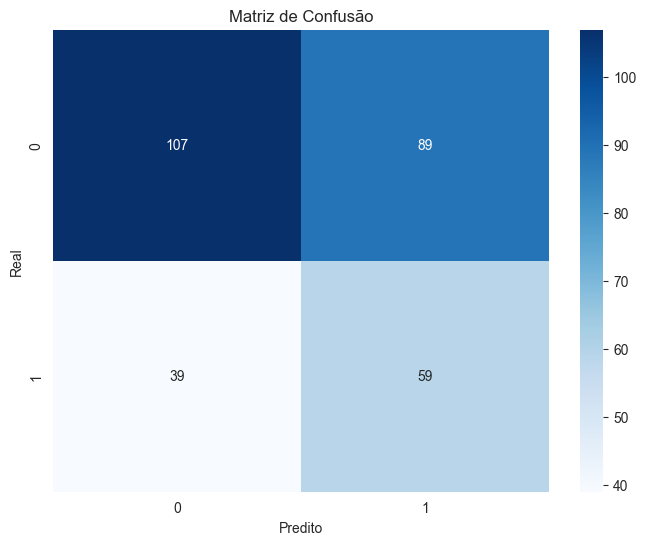

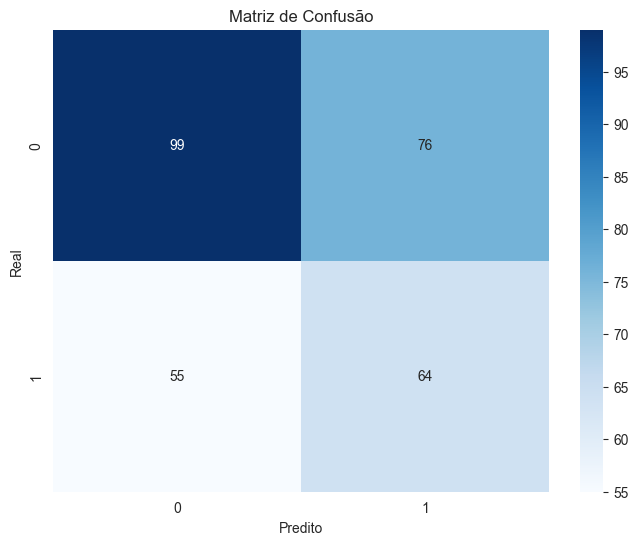

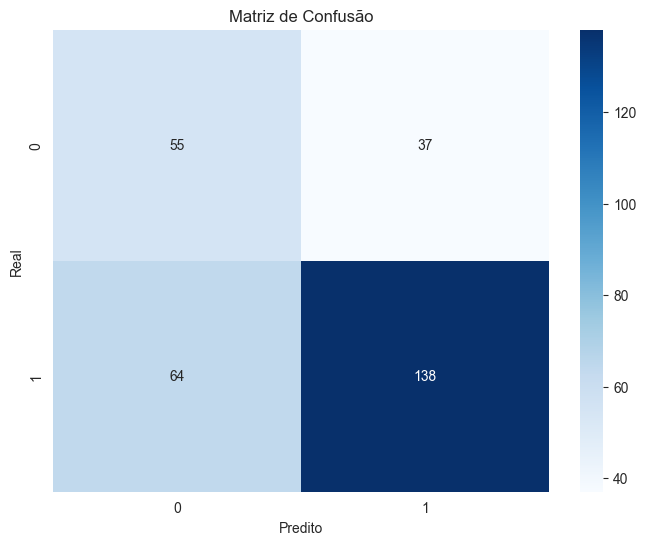


=== RELATÓRIO DE CLASSIFICAÇÃO - TESTE1 === 
              precision    recall  f1-score   support

           0       0.73      0.55      0.63       196
           1       0.40      0.60      0.48        98

    accuracy                           0.56       294
   macro avg       0.57      0.57      0.55       294
weighted avg       0.62      0.56      0.58       294


=== RELATÓRIO DE CLASSIFICAÇÃO - TESTE2 ===
              precision    recall  f1-score   support

           0       0.64      0.57      0.60       175
           1       0.46      0.54      0.49       119

    accuracy                           0.55       294
   macro avg       0.55      0.55      0.55       294
weighted avg       0.57      0.55      0.56       294


=== RELATÓRIO DE CLASSIFICAÇÃO - TESTE3 ===
              precision    recall  f1-score   support

           0       0.46      0.60      0.52        92
           1       0.79      0.68      0.73       202

    accuracy                           0.66   

In [1220]:
# Predições
y1_pred = modelo1_sklearn.predict(X1_test_scaled)
y1_pred_proba = modelo1_sklearn.predict_proba(X1_test_scaled)[:, 1]

y2_pred = modelo2_sklearn.predict(X2_test_scaled)
y2_pred_proba = modelo2_sklearn.predict_proba(X2_test_scaled)[:, 1]

y3_pred = modelo3_sklearn.predict(X3_test_scaled)
y3_pred_proba = modelo3_sklearn.predict_proba(X3_test_scaled)[:, 1]
# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("=== MÉTRICAS DE PERFORMANCE ===")
print(f"Acurácia: {accuracy_score(y1_test, y1_pred):.4f}")
print(f"Precisão: {precision_score(y1_test, y1_pred):.4f}")
print(f"Recall: {recall_score(y1_test, y1_pred):.4f}")
print(f"F1-Score: {f1_score(y1_test, y1_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y1_test, y1_pred_proba):.4f}")

print("=== MÉTRICAS DE PERFORMANCE ===")
print(f"Acurácia: {accuracy_score(y2_test, y2_pred):.4f}")
print(f"Precisão: {precision_score(y2_test, y2_pred):.4f}")
print(f"Recall: {recall_score(y2_test, y2_pred):.4f}")
print(f"F1-Score: {f1_score(y2_test, y2_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y2_test, y2_pred_proba):.4f}")

print("=== MÉTRICAS DE PERFORMANCE ===")
print(f"Acurácia: {accuracy_score(y3_test, y3_pred):.4f}")
print(f"Precisão: {precision_score(y3_test, y3_pred):.4f}")
print(f"Recall: {recall_score(y3_test, y3_pred):.4f}")
print(f"F1-Score: {f1_score(y3_test, y3_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y3_test, y3_pred_proba):.4f}")

# Matriz de confusão
cm = confusion_matrix(y1_test, y1_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

cm = confusion_matrix(y2_test, y2_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

cm = confusion_matrix(y3_test, y3_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()


# Relatório de classificação
print("\n=== RELATÓRIO DE CLASSIFICAÇÃO - TESTE1 === ")
print(classification_report(y1_test, y1_pred))

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO - TESTE2 ===")
print(classification_report(y2_test, y2_pred))

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO - TESTE3 ===")
print(classification_report(y3_test, y3_pred))


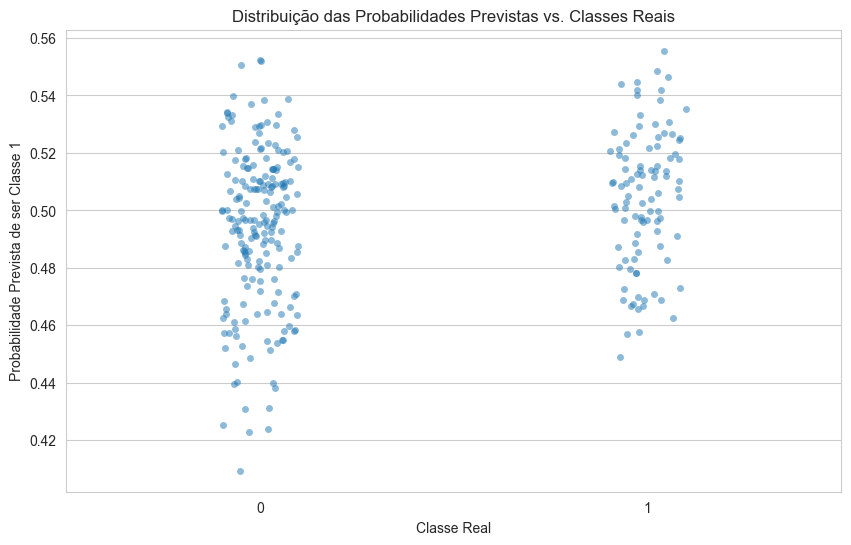

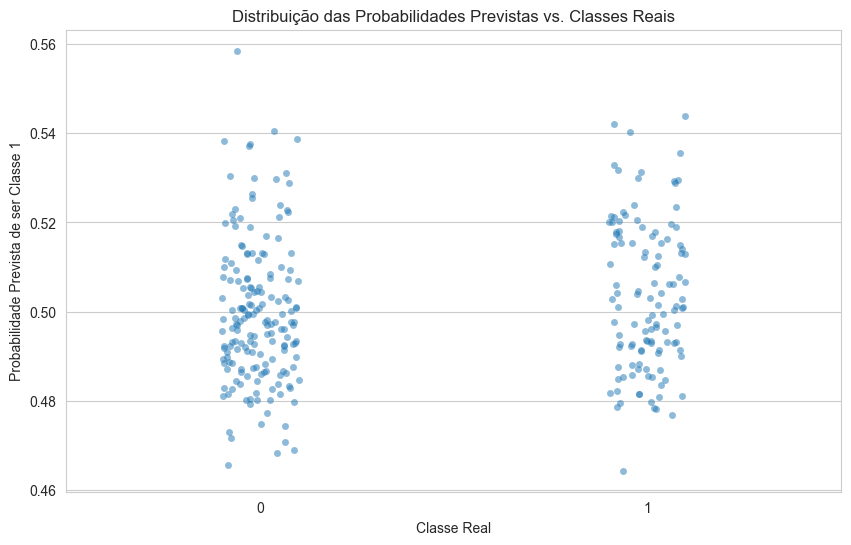

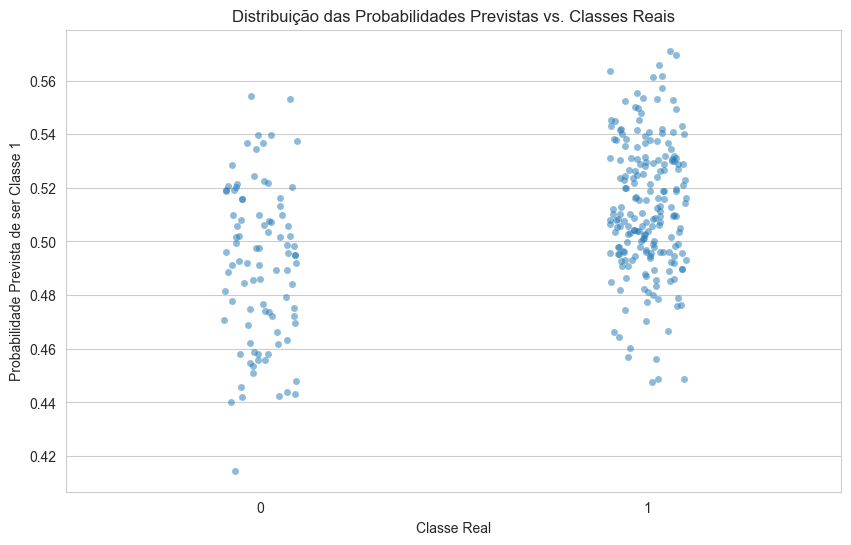

In [1221]:
# Criar um DataFrame para o plot de probabilidades
df_plot = pd.DataFrame({'real': y1_test, 'probabilidade': y1_pred_proba})

# Plotar a distribuição das probabilidades
plt.figure(figsize=(10, 6))
sns.stripplot(x='real', y='probabilidade', data=df_plot, jitter=True, alpha=0.5)
plt.title('Distribuição das Probabilidades Previstas vs. Classes Reais')
plt.ylabel('Probabilidade Prevista de ser Classe 1')
plt.xlabel('Classe Real')
plt.show()

# Idealmente, as probabilidades para a Classe Real 0 devem estar perto de 0
# e as probabilidades para a Classe Real 1 devem estar perto de 1.

# Criar um DataFrame para o plot de probabilidades
df_plot = pd.DataFrame({'real': y2_test, 'probabilidade': y2_pred_proba})

# Plotar a distribuição das probabilidades
plt.figure(figsize=(10, 6))
sns.stripplot(x='real', y='probabilidade', data=df_plot, jitter=True, alpha=0.5)
plt.title('Distribuição das Probabilidades Previstas vs. Classes Reais')
plt.ylabel('Probabilidade Prevista de ser Classe 1')
plt.xlabel('Classe Real')
plt.show()

# Idealmente, as probabilidades para a Classe Real 0 devem estar perto de 0
# e as probabilidades para a Classe Real 1 devem estar perto de 1.

# Criar um DataFrame para o plot de probabilidades
df_plot = pd.DataFrame({'real': y3_test, 'probabilidade': y3_pred_proba})

# Plotar a distribuição das probabilidades
plt.figure(figsize=(10, 6))
sns.stripplot(x='real', y='probabilidade', data=df_plot, jitter=True, alpha=0.5)
plt.title('Distribuição das Probabilidades Previstas vs. Classes Reais')
plt.ylabel('Probabilidade Prevista de ser Classe 1')
plt.xlabel('Classe Real')
plt.show()

# Idealmente, as probabilidades para a Classe Real 0 devem estar perto de 0
# e as probabilidades para a Classe Real 1 devem estar perto de 1.

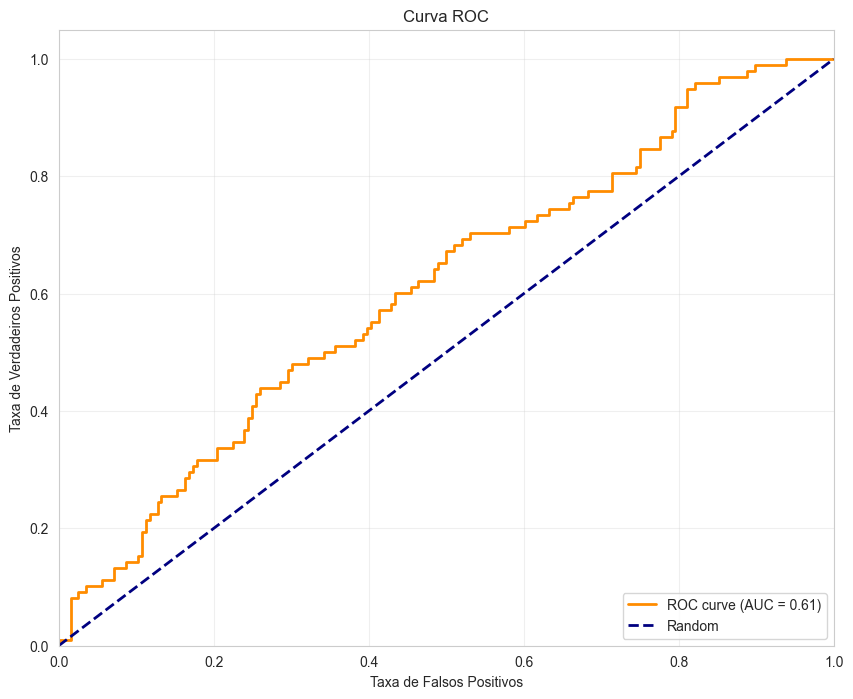

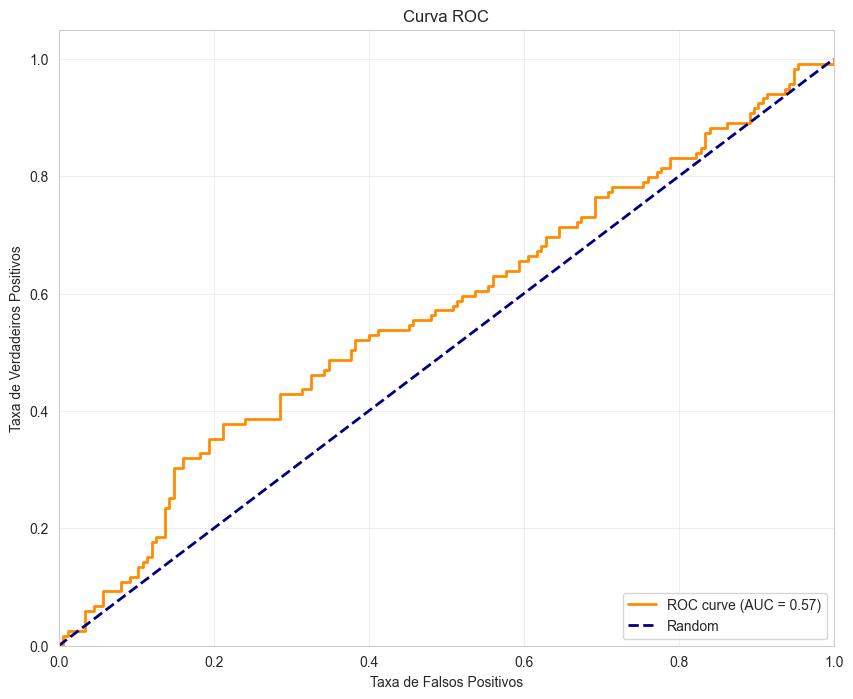

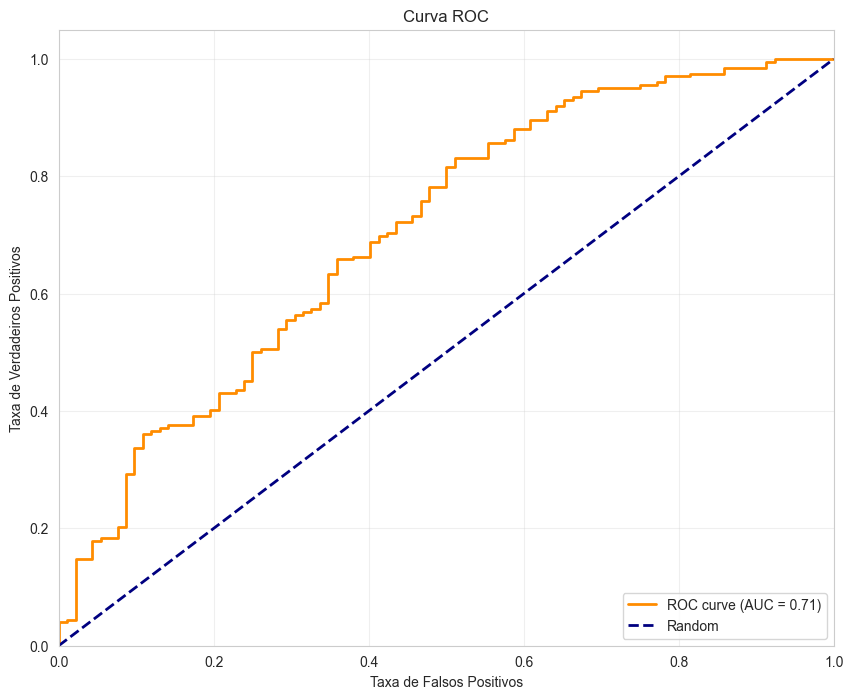

In [1222]:
# Calcular ROC
fpr, tpr, thresholds = roc_curve(y1_test, y1_pred_proba)
roc_auc = roc_auc_score(y1_test, y1_pred_proba)

# Plotar
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

fpr, tpr, thresholds = roc_curve(y2_test, y2_pred_proba)
roc_auc = roc_auc_score(y2_test, y2_pred_proba)

# Plotar
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

fpr, tpr, thresholds = roc_curve(y3_test, y3_pred_proba)
roc_auc = roc_auc_score(y3_test, y3_pred_proba)

# Plotar
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

--- Importância das Variáveis (Coeficientes) ---
  Feature  Coeficiente  Impacto_Absoluto
7     PSR    -0.045170          0.045170
2  TABAG4     0.043834          0.043834
3    SEXO     0.041806          0.041806
4    DIAB     0.032819          0.032819
8     PDR    -0.022254          0.022254
6     IMC    -0.016826          0.016826
5   ARTER     0.010049          0.010049
1     AH3     0.009595          0.009595
9     COL    -0.004039          0.004039
0  IDADE1    -0.001718          0.001718


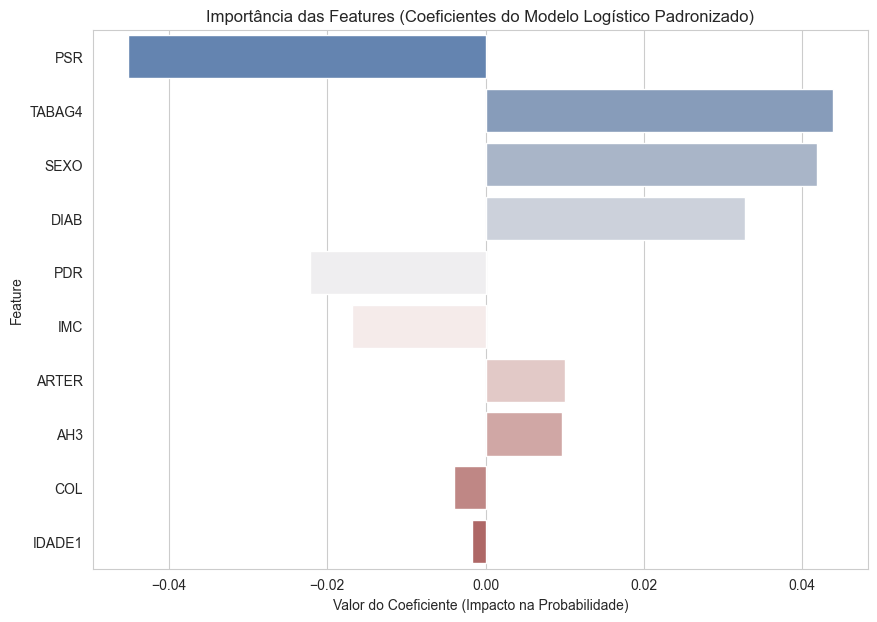

In [1225]:
# Use o 'model_scaled' do Passo 1
coeficientes = modelo1_sklearn.coef_[0]
nomes_features = var_indep1

# Criar um DataFrame para facilitar a visualização
df_coefs = pd.DataFrame({
    'Feature': nomes_features,
    'Coeficiente': coeficientes
})

# Ordenar por valor absoluto para ver os mais importantes
df_coefs['Impacto_Absoluto'] = df_coefs['Coeficiente'].abs()
df_coefs = df_coefs.sort_values(by='Impacto_Absoluto', ascending=False)

print("--- Importância das Variáveis (Coeficientes) ---")
print(df_coefs)

# Plotar o gráfico de barras
plt.figure(figsize=(10, 7))
sns.barplot(x='Coeficiente', y='Feature', data=df_coefs, palette='vlag')
plt.title('Importância das Features (Coeficientes do Modelo Logístico Padronizado)')
plt.xlabel('Valor do Coeficiente (Impacto na Probabilidade)')
plt.ylabel('Feature')
plt.show()